# 6_6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [19]:
import nasdaqdatalink

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '_J4sbHax3WKazooJCszx'

In [35]:
# in my project the most of the boats are in Germany, so I choosed the german GDP data
nasdaqdatalink.ApiConfig.api_key = '_J4sbHax3WKazooJCszx'
data = nasdaqdatalink.get_table('QDL/ODA', indicator='DEU_NID_NGDP')

In [36]:
data.head()

,indicator,date,value
None,,,
0,DEU_NID_NGDP,2028-12-31,24.007
1,DEU_NID_NGDP,2027-12-31,23.846
2,DEU_NID_NGDP,2026-12-31,23.736
3,DEU_NID_NGDP,2025-12-31,23.772
4,DEU_NID_NGDP,2024-12-31,23.695


In [37]:
data.shape

(49, 3)

In [38]:
data.columns

Index(['indicator', 'date', 'value'], dtype='object')

In [39]:
type(data)

pandas.core.frame.DataFrame

### 2. Subsetting, wrangling, and cleaning time-series data

In [42]:
# Reset index so that I can use the "Date" column as a filter

data_2 = data.reset_index()

In [43]:
data_2.head()

,None,indicator,date,value
0,0,DEU_NID_NGDP,2028-12-31,24.007
1,1,DEU_NID_NGDP,2027-12-31,23.846
2,2,DEU_NID_NGDP,2026-12-31,23.736
3,3,DEU_NID_NGDP,2025-12-31,23.772
4,4,DEU_NID_NGDP,2024-12-31,23.695


In [44]:
data_sub = data_2.loc[(data_2['date'] >= '1979-01-01') & (data_2['date'] < '2024-12-31')]

In [45]:
data_sub.shape

(44, 4)

In [46]:
data_sub.head()

,None,indicator,date,value
5,5,DEU_NID_NGDP,2023-12-31,23.751
6,6,DEU_NID_NGDP,2022-12-31,24.830
7,7,DEU_NID_NGDP,2021-12-31,23.290
8,8,DEU_NID_NGDP,2020-12-31,22.090
9,9,DEU_NID_NGDP,2019-12-31,22.121


In [ ]:
# Set the "date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.



In [54]:
data_sub.drop(['indicator'], axis=1, inplace=True) # Drop the "indicator" column.
data_sub.head()

,None,value
datetime,,
2023-12-31,5,23.751
2022-12-31,6,24.830
2021-12-31,7,23.290
2020-12-31,8,22.090
2019-12-31,9,22.121


In [55]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2023-12-31 to 1980-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   None    44 non-null     int64  
 1   value   44 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


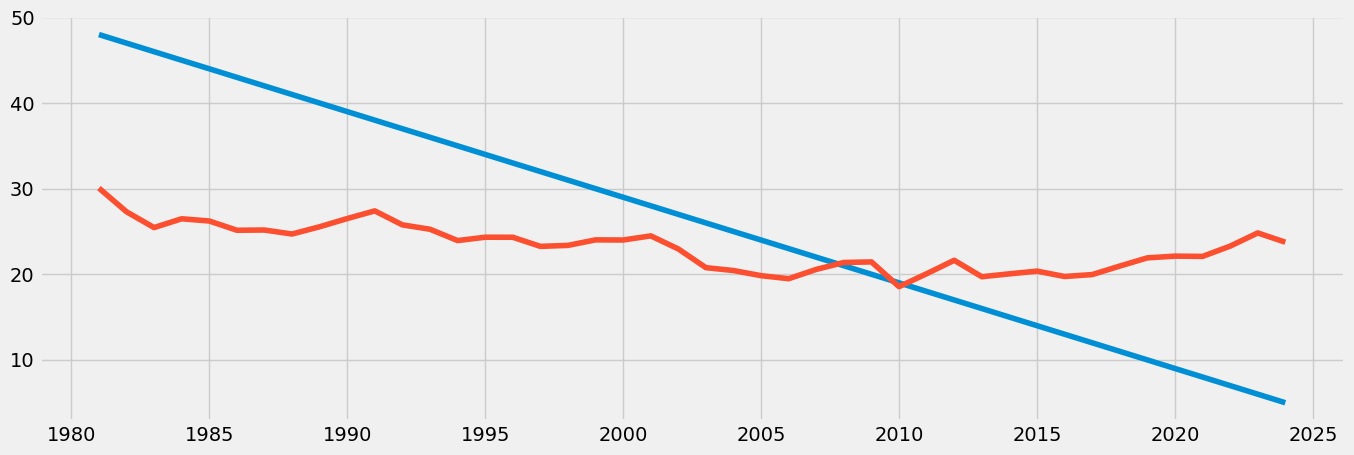

In [56]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [57]:
# Check for missing values (I don't have any)

data_sub.isnull().sum() 

None     0
value    0
dtype: int64

In [58]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

This data set has no seasonality, so I can not use sm.tsa.trend_decompose
I need to use another datase, but on the data.nasdaq.com the most of data sets are not free
The dataset which is in the CareerFoundry exercise is also not free any more, the CF lesson is outdated.
I don't want to pay for the data set, so I use a free dataset from kaggle

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTest.csv

In [70]:
#import new data

df = pd.read_csv(r'C:\Users\User\OneDrive\Dokumentumok\CF\Achievement 6\Boat_Sales\02 Data\Original Data\DailyDelhiClimateTest.csv')

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [71]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [72]:
data_sub2 = df[['date', 'meantemp']]

In [73]:
data_sub2.shape

(114, 2)

In [74]:
# Check for missing values (I don't have any)

data_sub2.isnull().sum() 

date        0
meantemp    0
dtype: int64

In [75]:
# Check for duplicates

dups = data_sub2.duplicated()
dups.sum()

# No dups!

0

In [76]:
data_sub2.head()

,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


In [77]:
# Set the "Date" column as the index

from datetime import datetime

data_sub2['datetime'] = pd.to_datetime(data_sub2['date']) # Create a datetime column from "Date.""
data_sub2 = data_sub2.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub2.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub2.head()

,meantemp
datetime,
2017-01-01,15.913043
2017-01-02,18.500000
2017-01-03,17.111111
2017-01-04,18.700000
2017-01-05,18.388889


In [78]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub2, model='additive')

In [79]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

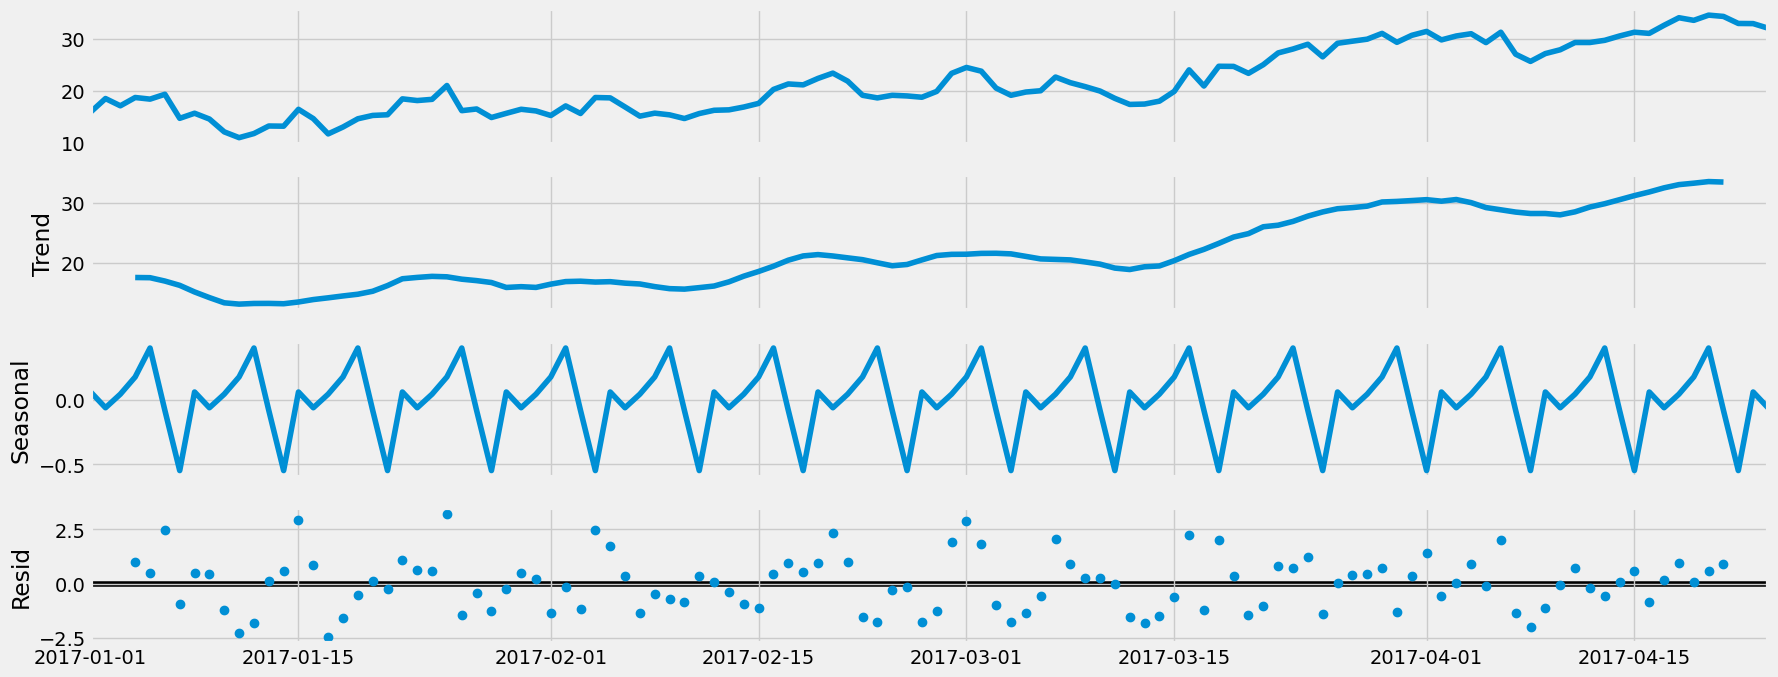

In [80]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [82]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why I need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub2['meantemp'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.096474
p-value                          0.716476
Number of Lags Used              0.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


Test statistic > than critical value = non-stationary data = forecast NO
Test statistic < than critical value = stationary data = forecast OK

#### non-stationary data = forecast NO


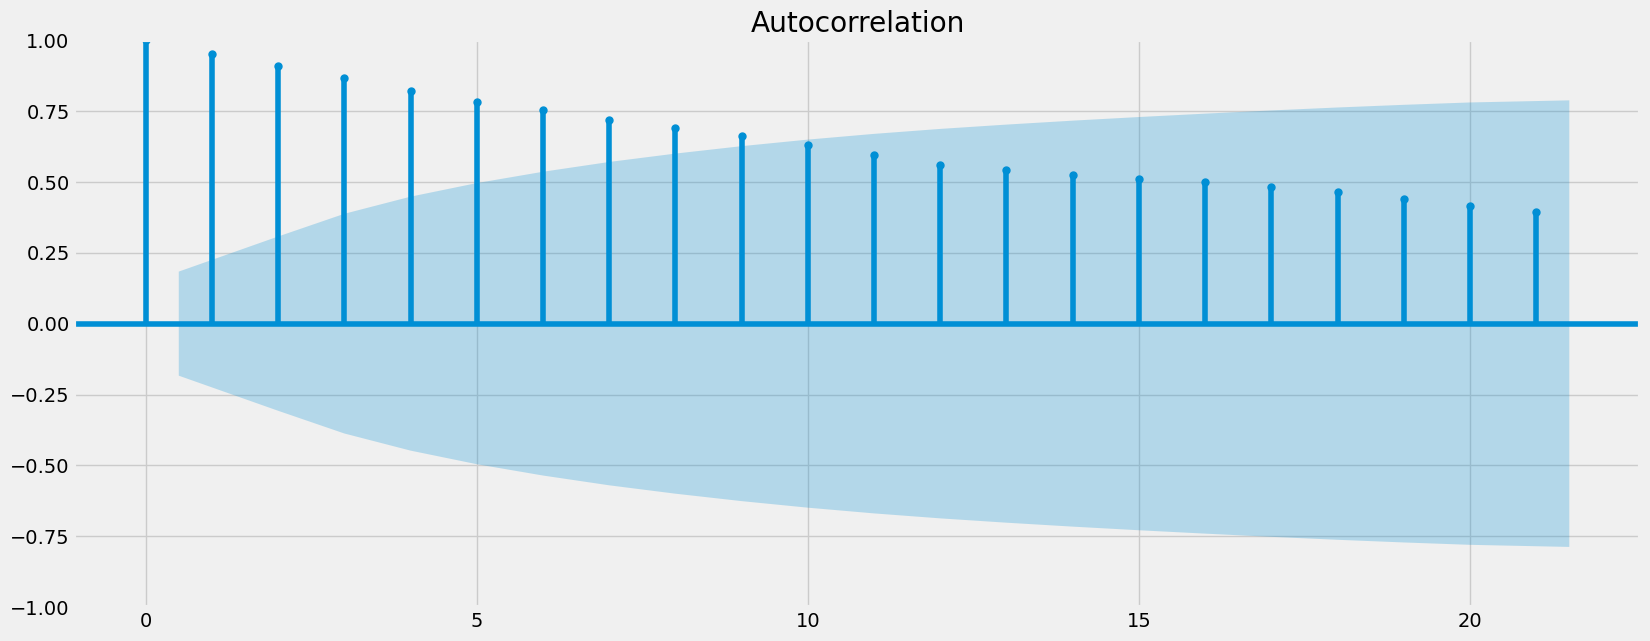

In [83]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, I import the autocorrelation and partial correlation plots

plot_acf(data_sub2)
plt.show()

### 5. Stationarizing Data

In [84]:
data_diff = data_sub2 - data_sub2.shift(1)
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [85]:
# Here, I remove the missing values that came about as a result of the differencing. 
# I need to remove these or you won't be able to run the Dickey-Fuller test.

data_diff.dropna(inplace = True)

In [86]:
data_diff.head()

,meantemp
datetime,
2017-01-02,2.586957
2017-01-03,-1.388889
2017-01-04,1.588889
2017-01-05,-0.311111
2017-01-06,0.929293


In [87]:
data_diff.columns

Index(['meantemp'], dtype='object')

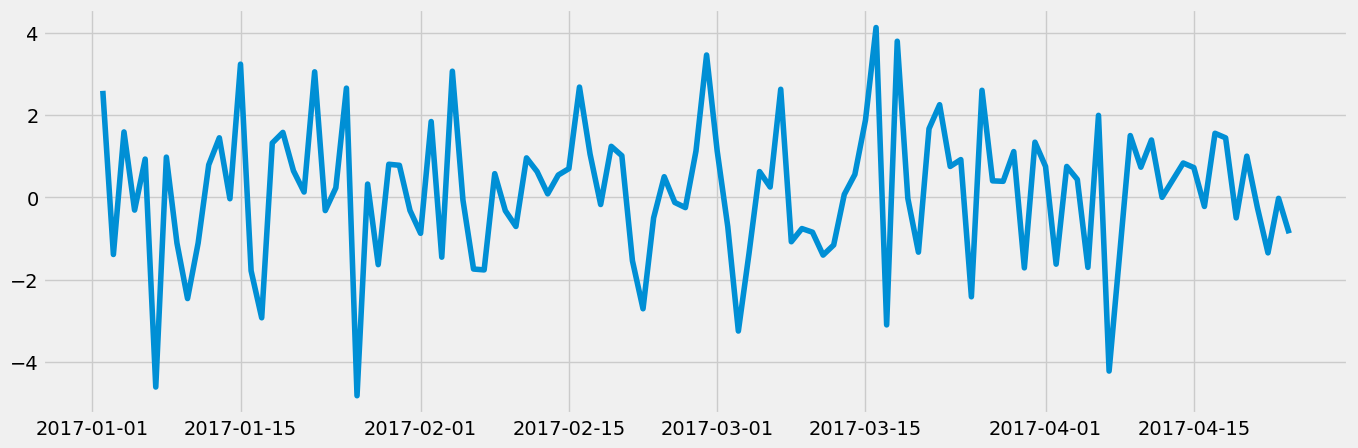

In [88]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [90]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.203580e+01
p-value                        2.805321e-22
Number of Lags Used            0.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


#### Test statistic -1.203580e+01 < than critical value   -2.887712e+00 = stationary data = forecast OK

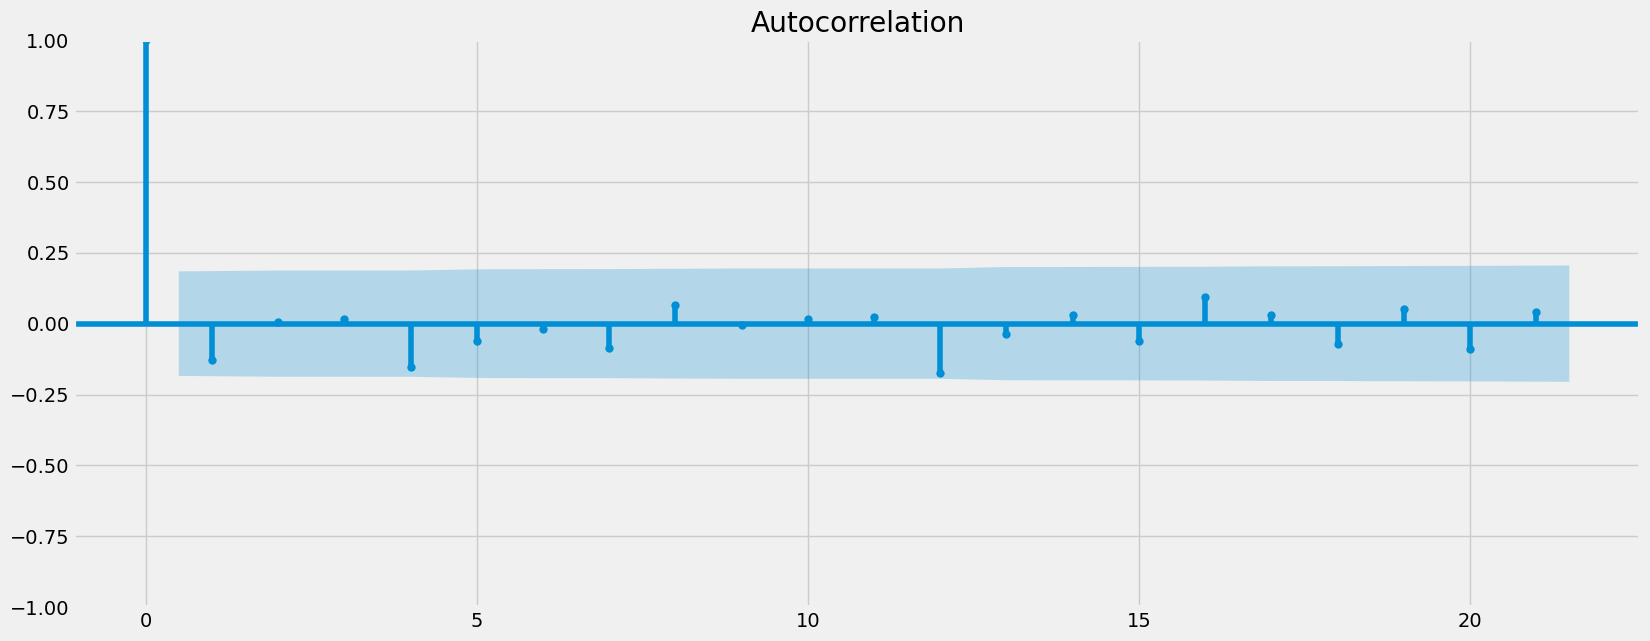

In [91]:
plot_acf(data_diff)
plt.show()